In [268]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import yfinance as yf
import math as m

In [269]:
# Enhanced chart aesthetics using seaborn
sns.set(style="whitegrid")

# Disabling 'SettingWithCopyWarning' for clean pandas operation
pd.options.mode.chained_assignment = None 

In [270]:
# Set up end and start times for historical data retrieval
# We choose one month of data for a relevant amount of recent historical data.
end = datetime.now()  # Current date and time
start = datetime(end.year, end.month - 1, end.day)  # Subtract one month from the current date

In [271]:
# Ticker selection for data retrieval
# Apple is chosen due to its high trade volume and interest among investors.
stock_name = 'NVDA'
stockticker = yf.Ticker(stock_name)

In [272]:
# Retrieve historical stock data using yfinance
asset_df = stockticker.history(interval="1d", start=start, end=end)

c:\Users\JOHNCY RODRIGUES\Desktop\Pro_Doing\OptionPricing\opt_pri\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


### Historical Stock Price Visualization
We visualize the closing price of Apple (AAPL) for the past month to observe its performance.
This visualization serves as the foundation for our subsequent financial analysis.

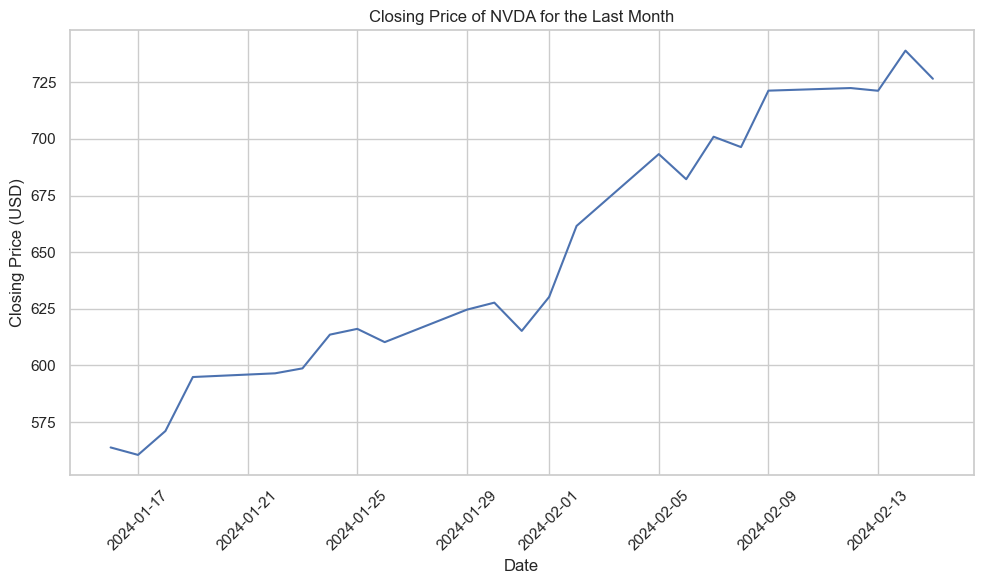

In [273]:
# Plotting the Closing Price over the last month
plt.figure(figsize=(10, 6))
plt.plot(asset_df["Close"], linestyle="-")
plt.title(f"Closing Price of {stock_name} for the Last Month")
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.grid(True)
plt.show()

### Option Analysis Setup
We proceed to set up the parameters for our options analysis. This includes specifying the option expiration date,
determining the risk-free rate, and calculating the time to expiration. These parameters are crucial for pricing options using the Black-Scholes model.

In [274]:
# Define option expiry date and risk-free rate
option_date = "2024-05-17"  # Expiry date of the option chosen arbitrarily for this example
bond_rate = 0.0464  # Example risk-free rate, assumed to be the yield on a 3-month U.S. Treasury bill

In [275]:
# Convert the expiry to a datetime object and calculate time to expiry
option_expiry_datetime = datetime.strptime(option_date, "%Y-%m-%d")
time_to_exp = (option_expiry_datetime - end).days  # Days to expiry
years_to_exp = time_to_exp / 365  # Convert days to years for Black-Scholes model

In [276]:
# Fetch option chain data and clean column names
call_data = stockticker.option_chain(option_date).calls
call_data.columns = [col.replace(' ', '') for col in call_data.columns]  # Remove spaces from column names

In [277]:
# Select a specific call option as an example
call_option = call_data.iloc[18]  # The 19th option is chosen arbitrarily for this example

# Print selected option details
print(f"The strike price of the option is {call_option['currency']} {call_option['strike']}")
print(f"The time to expiry of the option in years is {years_to_exp}")
print(f"The risk-free interest rate for the period is {bond_rate}")
print(f"The current asset price is {call_option['currency']} {asset_df['Close'][-1]}")

The strike price of the option is USD 180.0
The time to expiry of the option in years is 0.2465753424657534
The risk-free interest rate for the period is 0.0464
The current asset price is USD 726.5800170898438


C:\Users\JOHNCY RODRIGUES\AppData\Local\Temp\ipykernel_19744\2768537907.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The current asset price is {call_option['currency']} {asset_df['Close'][-1]}")


### Historical Volatility Calculation
Historical volatility is a measure of the variation of the asset price over time.
We calculate this using the standard deviation of the asset's log returns, which is a common approach in financial analysis.

In [278]:
# Calculate log returns and historical volatility
asset_df['LogReturn'] = np.log(asset_df['Close'] / asset_df['Close'].shift(1))
# Calculate the annualized volatility, assuming 252 trading days per year
annualized_volatility = np.sqrt(252) * asset_df['LogReturn'].std()

print(f"The historical volatility of the asset based on 1 month of observations is {annualized_volatility:.4f}")

The historical volatility of the asset based on 1 month of observations is 0.3307


### Black-Scholes Option Pricing Model
The Black-Scholes model is a mathematical model for pricing European options.
We define functions for the model, which will allow us to estimate the theoretical price of a call option.

In [279]:
# Define functions for Black-Scholes calculations
def N(d):
    """Cumulative standard normal distribution"""
    return (0.5 * (1 + m.erf(d / np.sqrt(2))))

def d1(S, E, T, r, sigma):
    """Calculate d1 used in the Black-Scholes formula"""
    return ((np.log(S / E) + (r + sigma ** 2 / 2) * (T)) / (sigma * np.sqrt(T)))

def d2(S, E, T, r, sigma):
    """Calculate d2 used in the Black-Scholes formula"""
    return ((np.log(S / E) + (r - sigma ** 2 / 2) * (T)) / (sigma * np.sqrt(T)))
 
def BlackScholesCall(S, E, T, r, sigma):
    """Calculate Black-Scholes option price for a call option"""
    return S * N(d1(S, E, T, r, sigma)) - E * np.exp(-r * T) * N(d2(S, E, T, r, sigma))

In [280]:
# Calculate the Black-Scholes value for the selected call option
S = asset_df["Close"][len(asset_df)-1]  # Current stock price
E = call_option["strike"]  # Strike price of the option
T = years_to_exp  # Time to expiry in years
r = bond_rate  # Risk-free rate
sigma = annualized_volatility  # Annualized volatility of the stock

# Calculate the theoretical price using the Black-Scholes model
black_scholes_val = BlackScholesCall(S, E, T, r, sigma)

print(f"For our chosen option, the Black-Scholes value is: {black_scholes_val:.2f}")
print(f"In reality, the current ask price is: {call_option['ask']}")

For our chosen option, the Black-Scholes value is: 548.63
In reality, the current ask price is: 0.0


C:\Users\JOHNCY RODRIGUES\AppData\Local\Temp\ipykernel_19744\2549791102.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = asset_df["Close"][len(asset_df)-1]  # Current stock price


### Strike Price Range Analysis
To analyze a range of strike prices, we calculate the Black-Scholes value for each strike and compare it with the actual market price.
This comparison can reveal insights into market sentiment and potential mispricings.

In [281]:
# Create a range of strike prices to analyze
strike_range = np.arange(120, 320, 5)

# Get indices for the options with the chosen strike prices
strike_indices = [call_data.index[call_data['strike'] == strike][0] for strike in strike_range if not call_data[call_data['strike'] == strike].empty]

# Calculate Black-Scholes value for each strike price
BlackScholesVals = {strike: BlackScholesCall(S, strike, T, r, sigma) for strike in strike_range}

# Retrieve the actual market prices for the options
RealVals = {call_data['strike'][i]: call_data['ask'][i] for i in strike_indices}

# Convert the dictionaries to DataFrames
BlackScholesDF = pd.DataFrame(list(BlackScholesVals.items()), columns=['Strike', 'Black Scholes Value'])
RealValsDF = pd.DataFrame(list(RealVals.items()), columns=['Strike', 'Real Value'])

# Merge the two DataFrames on the Strike column
comparison_df = pd.merge(BlackScholesDF, RealValsDF, on='Strike')

# Adding Time to Expiry for reference
comparison_df['Time to Expiry'] = T

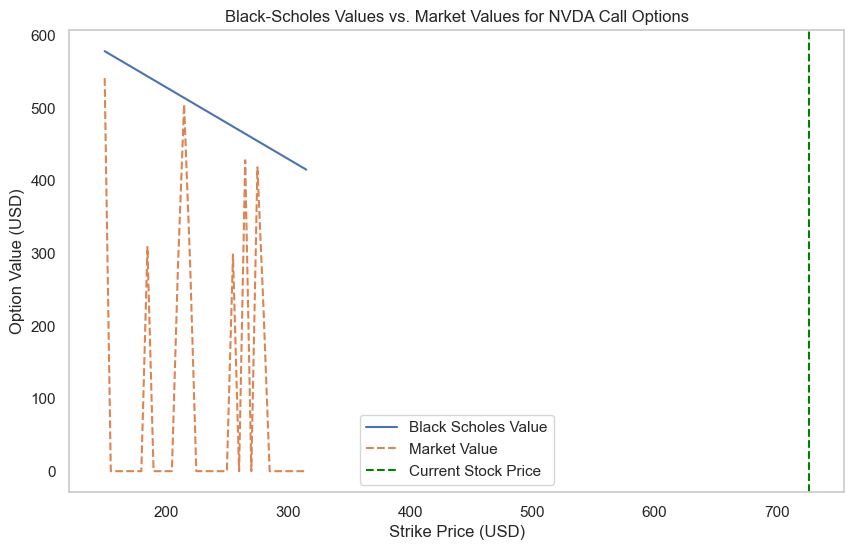

In [282]:
# Plot comparison of Black-Scholes values vs. Observed Market Values
plt.figure(figsize=(10, 6))
plt.plot(comparison_df["Strike"], comparison_df["Black Scholes Value"], label="Black Scholes Value", linestyle='-')
plt.plot(comparison_df["Strike"], comparison_df["Real Value"], label="Market Value", linestyle='--')
plt.axvline(S, color="green", linestyle="--", label="Current Stock Price")
plt.xlabel("Strike Price (USD)")
plt.ylabel("Option Value (USD)")
plt.title("Black-Scholes Values vs. Market Values for NVDA Call Options")
plt.legend()
plt.grid()
plt.show()

### Implied Volatility Calculation
Implied volatility represents the market's view of the likelihood of changes in a given security's price.
We use the Newton-Raphson method to iterate and find the implied volatility that aligns the Black-Scholes model price with the market price.

In [283]:
# Define the Newton-Raphson method to calculate implied volatility
def newton_raphson_volatility(S, E, T, r, C):
    """Calculate implied volatility using the Newton-Raphson method."""
    # Initial guess for implied volatility
    sigma_guess = 0.5
    tol = 1e-6  # Tolerance level for stopping the iteration

    for _ in range(200):  # Maximum number of iterations
        price = BlackScholesCall(S, E, T, r, sigma_guess)
        vega = S * N(d1(S, E, T, r, sigma_guess)) * m.sqrt(T)  # Vega is the derivative of the price with respect to volatility
        # It measures the sensitivity of the option price to changes in volatility

        # Calculate the difference between the Black-Scholes price and the actual market price
        difference = price - C

        # Update the guess for implied volatility using the Newton-Raphson method
        sigma_new = sigma_guess - difference / vega

        # Check if the change is within the specified tolerance
        if abs(sigma_new - sigma_guess) < tol:
            return sigma_new

        # Update the guess for the next iteration
        sigma_guess = sigma_new

    # If the method doesn't converge, return None
    return None


In [284]:
# Add a new column to the comparison DataFrame for implied volatility
comparison_df['Implied Volatility'] = np.nan

# Calculate implied volatility for each option in the DataFrame
for index, row in comparison_df.iterrows():
    implied_vol = newton_raphson_volatility(S, row['Strike'], T, r, row['Real Value'])
    comparison_df.at[index, 'Implied Volatility'] = implied_vol

# Display the DataFrame
print(comparison_df)

    Strike  Black Scholes Value  Real Value  Time to Expiry  \
0      150           578.286401      541.15        0.246575   
1      155           573.343281        0.00        0.246575   
2      160           568.400160        0.00        0.246575   
3      165           563.457040        0.00        0.246575   
4      170           558.513919        0.00        0.246575   
5      175           553.570799        0.00        0.246575   
6      180           548.627678        0.00        0.246575   
7      185           543.684558      308.70        0.246575   
8      190           538.741437        0.00        0.246575   
9      195           533.798317        0.00        0.246575   
10     200           528.855196        0.00        0.246575   
11     205           523.912076        0.00        0.246575   
12     210           518.968955      283.10        0.246575   
13     215           514.025835      505.25        0.246575   
14     220           509.082714      282.20        0.24

C:\Users\JOHNCY RODRIGUES\AppData\Local\Temp\ipykernel_19744\2781167030.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_new = sigma_guess - difference / vega
C:\Users\JOHNCY RODRIGUES\AppData\Local\Temp\ipykernel_19744\817938093.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return ((np.log(S / E) + (r + sigma ** 2 / 2) * (T)) / (sigma * np.sqrt(T)))
C:\Users\JOHNCY RODRIGUES\AppData\Local\Temp\ipykernel_19744\817938093.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return ((np.log(S / E) + (r - sigma ** 2 / 2) * (T)) / (sigma * np.sqrt(T)))
C:\Users\JOHNCY RODRIGUES\AppData\Local\Temp\ipykernel_19744\2781167030.py:17: RuntimeWarning: invalid value encountered in scalar divide
  sigma_new = sigma_guess - difference / vega


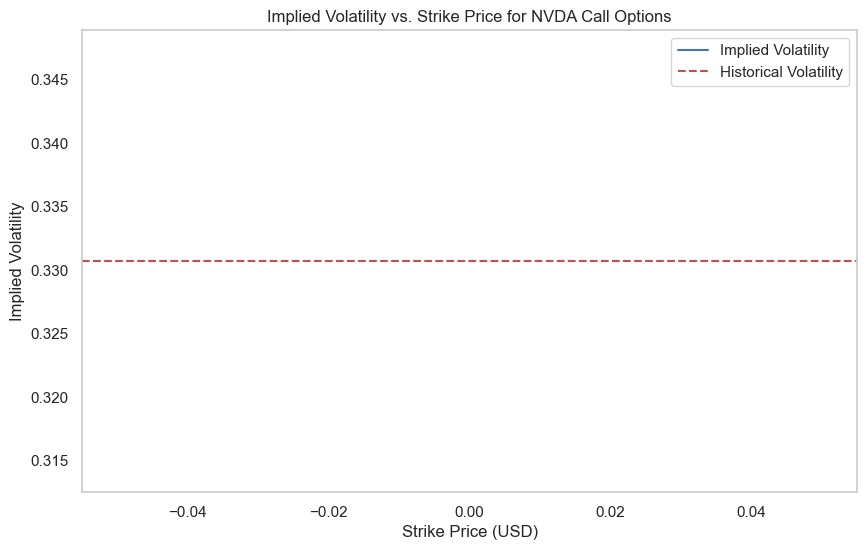

In [285]:
# Plot the implied volatility against strike prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df["Strike"], comparison_df["Implied Volatility"], label="Implied Volatility", linestyle='-')
plt.axhline(y=annualized_volatility, color='r', linestyle='--', label="Historical Volatility")
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility vs. Strike Price for NVDA Call Options")
plt.legend()
plt.grid()
plt.show()

### Conclusion
Through this analysis, we have demonstrated the application of the Black-Scholes model to real market data,
compared theoretical option values to actual market values, and calculated implied volatility using the Newton-Raphson method.
This approach provides a comprehensive understanding of option pricing and the insights that can be drawn from it.